## STEP 4 - Interest Rate prediction

The fourth part of the project aims to automate LendingClub's lending decisions fully by creating a prediction model that predict loan interest rate This model will utilize data from LendingClub to make predictions loan interest rate prediction. Why this model will be useful for Lending Club?:
 
* **Improved risk assessment**: By using a predictive model to determine interest rates, Lending Club can better assess the risk of each loan applicant. This can lead to more accurate pricing of loans, which can reduce default rates and improve profitability.

* **Increased efficiency**: By automating the interest rate determination process, Lending Club can reduce the time and resources needed to manually assess loan applications. This can increase efficiency and reduce costs.

* **Enhanced customer experience**: With a more accurate and automated interest rate determination process, Lending Club can provide a better customer experience by quickly and accurately providing loan offers to applicants.

* **Competitive advantage**: By using predictive modeling to determine interest rates, Lending Club can gain a competitive advantage in the marketplace. This can help attract new customers and increase market share.

Overall, a predictive model for interest rate determination can be a powerful tool for Lending Club. It can help the company make more informed decisions about loan pricing and risk assessment, which can lead to increased profitability and customer satisfaction.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import helpers
import warnings 
 
from imblearn.pipeline import Pipeline  
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

/Users/emabaranauskaite/Desktop/Turing/ebaran-ML1.3/lending_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

In [3]:
''' Reading accepted dataset '''
df_accepted = pd.read_csv("lending-club/accepted.csv")
df_accepted = df_accepted.drop_duplicates()

In [4]:
''' Removing rows with missing grade '''
df_accepted = df_accepted[df_accepted.grade.isnull() == False]

In [5]:
''' Dropping columns that have too much missing values '''
cols_to_remove = helpers.get_cols_with_large_missing_vals(df_accepted)

In [6]:
''' Appending columns to remove with id column '''
cols_to_remove = list(cols_to_remove.keys())
cols_to_remove.append("id")

In [7]:
''' Dropping columns that have too many missing values'''
df_accepted = df_accepted.drop(cols_to_remove, axis=1)

We can see that there are more columns that seem not to have very informative meaning. For instance, url or zip_code. Some date columns are also not meaningful.

In [8]:
''' Creating list with more missing values'''
more_useless_cols = ['url', 'pymnt_plan', 'title', 'zip_code',
                     'last_pymnt_d', 'debt_settlement_flag',
                     'issue_d', 'last_credit_pull_d', 'earliest_cr_line',
                     'sec_app_earliest_cr_line', 'next_pymnt_d']

In [9]:
''' Dropping useless columns '''
df_accepted = df_accepted.drop(more_useless_cols, axis=1)

## EDA - exploratory data analysis

### What is Loan Grade?
The **loan grades** in Lending Club are determined before the loan is accepted by investors. Lending Club uses a proprietary credit model to assign grades to loans based on factors such as credit history, income, employment status, and loan amount. The grades range from A to G, with A being the least risky and G being the most risky. Once a loan is graded, it is made available for investors to fund. The loan grades do not change after the loan is accepted or after the first installment is made.

Target Features:
* **grade**
* **subgrade**
* **int_rate**

Set only afert knowing loan grade (Data Leakage):
* **installment**: refers to the periodic payment you make to repay your loan over time.
* **chargeoff_within_12_mths**, **sec_app_chargeoff_within_12_mths**: this feature may represent data leakage because it reflects the outcome of the loan, which is not known at the time of loan application.
* **delinq_2yrs**, **inq_last_6mths**, **mths_since_last_delinq**, **mths_since_last_record**, **pub_rec**, **pub_rec_bankruptcies** **collections_12_mths_ex_med**, **sec_app_collections_12_mths_ex_med**, **mths_since_last_major_derog**, **sec_app_mths_since_last_major_derog**, **acc_now_delinq**, **delinq_amnt**, **num_accts_ever_120_pd**, **num_tl_30dpd**, **num_tl_90g_dpd_24m**, **sec_app_inq_last_6mths**: These variables relate to the borrower's credit history and may be useful for predicting loan grade, but they could also be considered part of the outcome (default) and therefore cause data leakage. Some of these features may indeed be correlated with the outcome (i.e., whether or not the borrower will default on the loan), but they are not considered part of the outcome itself. Rather, they are additional pieces of information about the borrower that the lender may use to assess their creditworthiness and determine whether to approve the loan and at what interest rate.
* **total_pymnt**, **total_pymnt_inv**, **total_rec_prncp**, **total_rec_int**, **total_rec_late_fee**, **recoveries**, **collection_recovery_fee**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **last_pymnt_amnt**, **last_credit_pull_d**, **last_fico_range_high**, **last_fico_range_low**: These variables are related to payments made by the borrower after the loan has been issued, and would not be known at the time the loan grade is assigned.
* **funded_amnt** and **funded_amnt_inv**: set only after issuing loan 
* **hardship_flag** indicates whether the borrower has requested a hardship plan due to financial difficulties that affect their ability to make payments on time. This is usually set after the loan is issued and the borrower requests a hardship plan.
* **disbursement_method** specifies how the borrower received the funds from the loan. This is typically set after the loan is approved and the borrower agrees to the terms of the loan, and before the funds are disbursed.
* **loan_status**: This is the current status of the loan, such as "Current", "Fully Paid", "Late (16-30 days)", "Charged Off", etc. This information is not available until after the loan has been issued.
* **out_prncp**: This is the remaining outstanding principal balance on the loan. It is updated as the borrower makes payments on the loan.
* **out_prncp_inv**: This is the remaining outstanding principal balance on the loan that is held by investors. Like out_prncp, it is updated as the borrower makes payments on the loan.
* **mths_since_rcnt_il**, **mths_since_recent_bc**, **mths_since_recent_bc_dlq**, and **mths_since_recent_inq** all measure the number of months since the borrower's most recent installment loan, recent bankcard account, recent bankcard delinquency, and recent inquiry, respectively. These values would not be available at the time of loan grade determination because they require time to accumulate.
* **open_acc_6m**, **open_act_il**, **sec_app_open_act_il**, **open_il_12m**, **open_il_24m**, **total_bal_il**, and **il_util** all depend on the borrower's current credit utilization and account status, which can change over time. These values would not be available at the time of loan grade determination because they could be different at the time of application versus the time of loan grade determination.
* **policy_code**: This feature is always equal to 1 and provides no useful information for predicting loan grade.
* **revol_util** and **sec_app_revol_util**: The revol_util value in the loan data refers to the revolving line utilization rate at the time the loan was issued, so it is included for the new loan. Therefore, it won't be useful to set loan grade.
* **revol_bal_joint**: set at the time the loan is issued. This feature represents the total revolving balance on all accounts at the time the borrower applied for the loan, including both the borrower and any co-borrowers or joint account holders. 


Not useful:
* **emp_title**: credit information of user would be more important than employment title.
* **desc**: This variable contains free-form text entered by the borrower, and may not be useful for predicting loan grade. **Purpose** will be more useful.
* **issue_d**: This variable is the date the loan was issued and would not be useful for predicting loan grade.
* **initial_list_status**: This variable is related to how the loan was listed on Lending Club's platform and may not be useful for predicting loan grade.
* **inq_fi** or **open_rv_12m** may not be very relevant in predicting loan grade or default risk. These features may provide additional information, but they may not be as important as other features in the dataset.
* **application_type**: this feature indicates whether the loan application was made by an individual borrower or a joint application with another person.

In [10]:
''' Creating list with columns to drop '''
drop_cols = ['desc', 'issue_d', 'revol_util',  'sec_app_revol_util', 'initial_list_status', 'installment', 'chargeoff_within_12_mths', 'sec_app_chargeoff_within_12_mths', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'pub_rec', 'pub_rec_bankruptcies', 'collections_12_mths_ex_med', 'sec_app_collections_12_mths_ex_med', 'mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog', 'acc_now_delinq', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'sec_app_inq_last_6mths', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'addr_state', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'disbursement_method', 'loan_status', 'out_prncp', 'out_prncp_inv', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'open_acc_6m', 'open_act_il', 'sec_app_open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'il_util', 'policy_code']

In [11]:
''' Dropping rows of columns that have less or equal 200 missing values'''
results = df_accepted.isnull().sum() 
for i in range(0, len(results)): 
    if results[i] <= 200:
        col = results.index[i]
        df_accepted = df_accepted.dropna(subset=col) 

In [12]:
''' Creating list of targets '''
targets = ['grade', 'sub_grade', 'int_rate']

In [13]:
''' Dropping columns that will not be useful for prediction'''
df_accepted = df_accepted.drop(columns=drop_cols, errors='ignore')

Since there is in the dataset both individual and joint applications. I'll only consider individual rows that do not have a single feature in "joint" cols. And joint applications that do not have missing values in "joint" columns

In [14]:
''' Taking individual loans without joint values '''
df_individual = df_accepted[df_accepted[['verification_status_joint', 'dti_joint', 'sec_app_open_acc',
                                         'sec_app_fico_range_low', 'sec_app_fico_range_high',
                                         'annual_inc_joint']].isnull().all(axis=1)]

In [15]:
''' Taking joint loans without missing joint values '''
df_joint = df_accepted[df_accepted[['verification_status_joint', 'dti_joint', 'sec_app_open_acc', 'sec_app_fico_range_low',
                                    'sec_app_fico_range_high', 'annual_inc_joint']].notnull().all(axis=1)]

In [16]:
''' Combining final dataset with joint and individual loans '''
df_accepted = pd.concat([df_joint, df_individual], ignore_index=True)

In [17]:
df_accepted = helpers.remove_num_outliers(df_accepted, nunique=100000, thres=0.99)

In [18]:
df = df_accepted.copy()
df = helpers.remove_outliers_col(df, "loan_amnt", 0.99)
df = helpers.remove_outliers_col(df, "annual_inc", 0.99)
df = helpers.remove_outliers_col(df, "dti", 0.99)
df = helpers.remove_outliers_col(df, "fico_range_low", 0.99)
len(df), len(df_accepted)

(1511049, 1784510)

In [19]:
df_accepted = df.copy()

## Step 4

In [20]:
df_accepted_step4 = helpers.stratified_sample(df_accepted, 'grade')

In [21]:
df_step4_targets = df_accepted_step4[["int_rate"]]

### EDA

#### Loan Amount

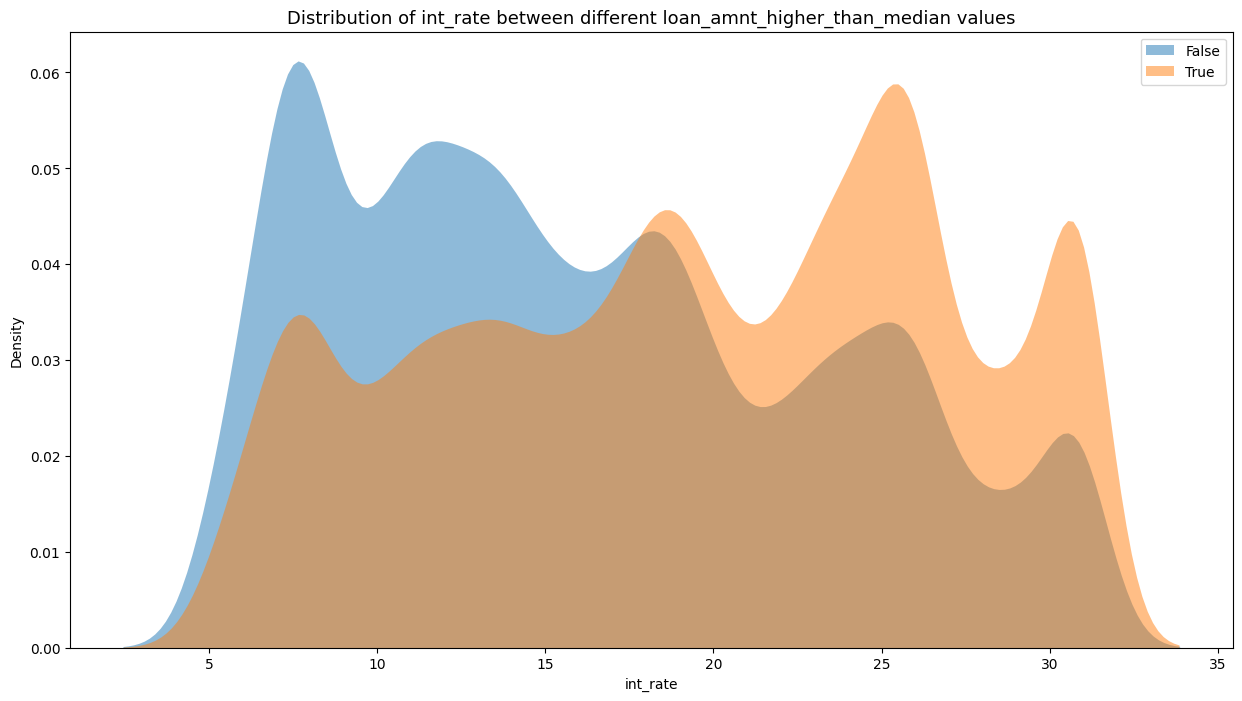

In [22]:
df = df_accepted_step4.copy()
loan_amnt_median = df_accepted_step4.loan_amnt.median()
df['loan_amnt_higher_than_median'] = df_accepted_step4.loan_amnt >= loan_amnt_median
helpers.plot_kde_plot(df, 'int_rate', 'loan_amnt_higher_than_median')

#### Annual Income

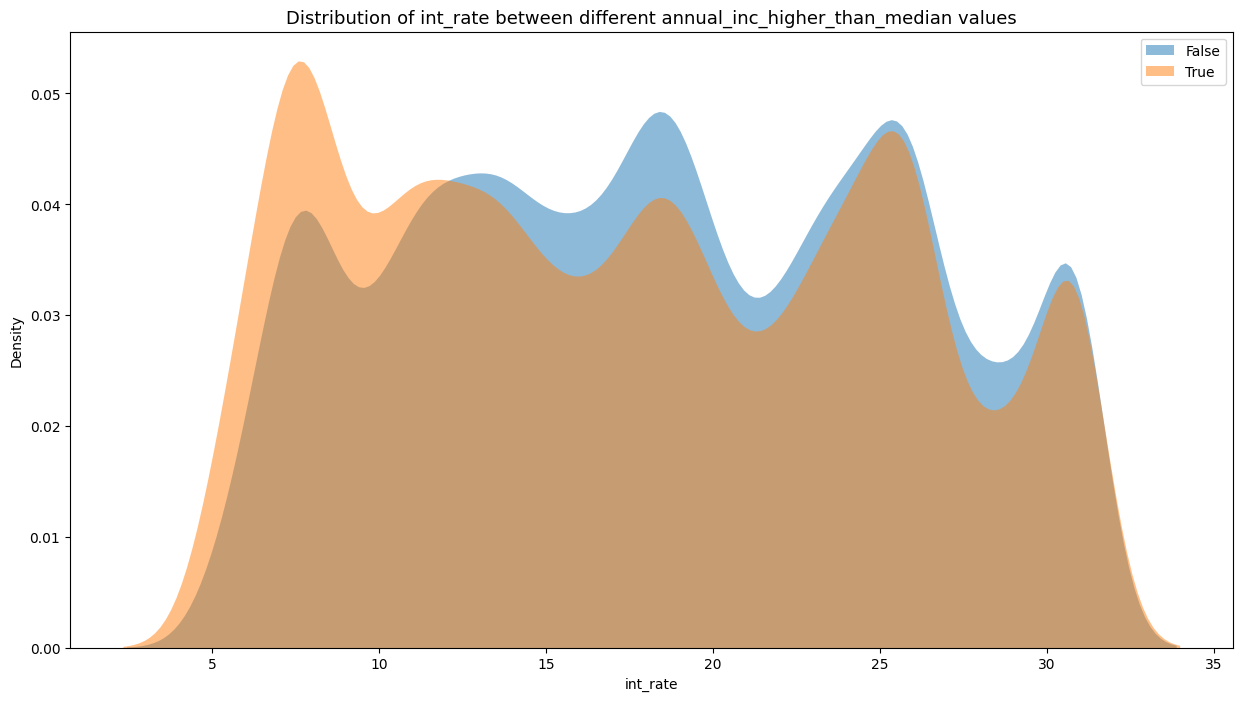

In [23]:
df = df_accepted_step4.copy()
annual_inc_median = df_accepted_step4.annual_inc.median()
df['annual_inc_higher_than_median'] = df_accepted_step4.annual_inc >= annual_inc_median
helpers.plot_kde_plot(df, 'int_rate', 'annual_inc_higher_than_median')

#### Term

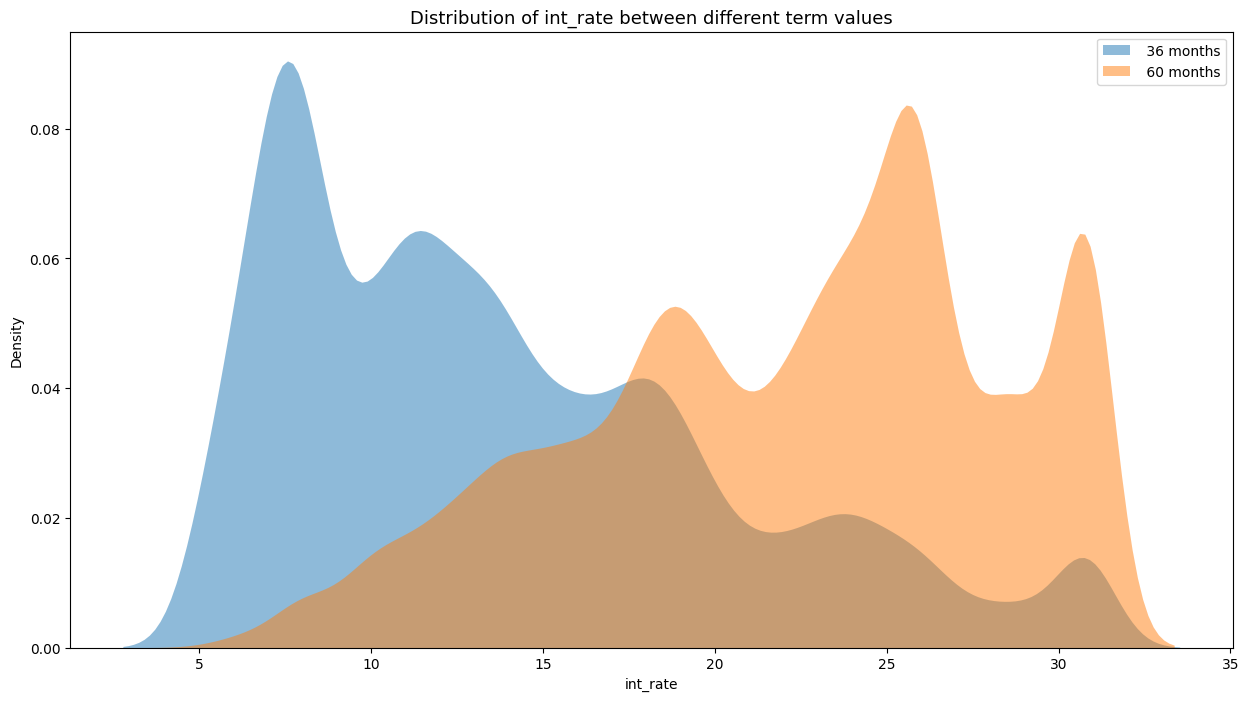

In [24]:
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'term')

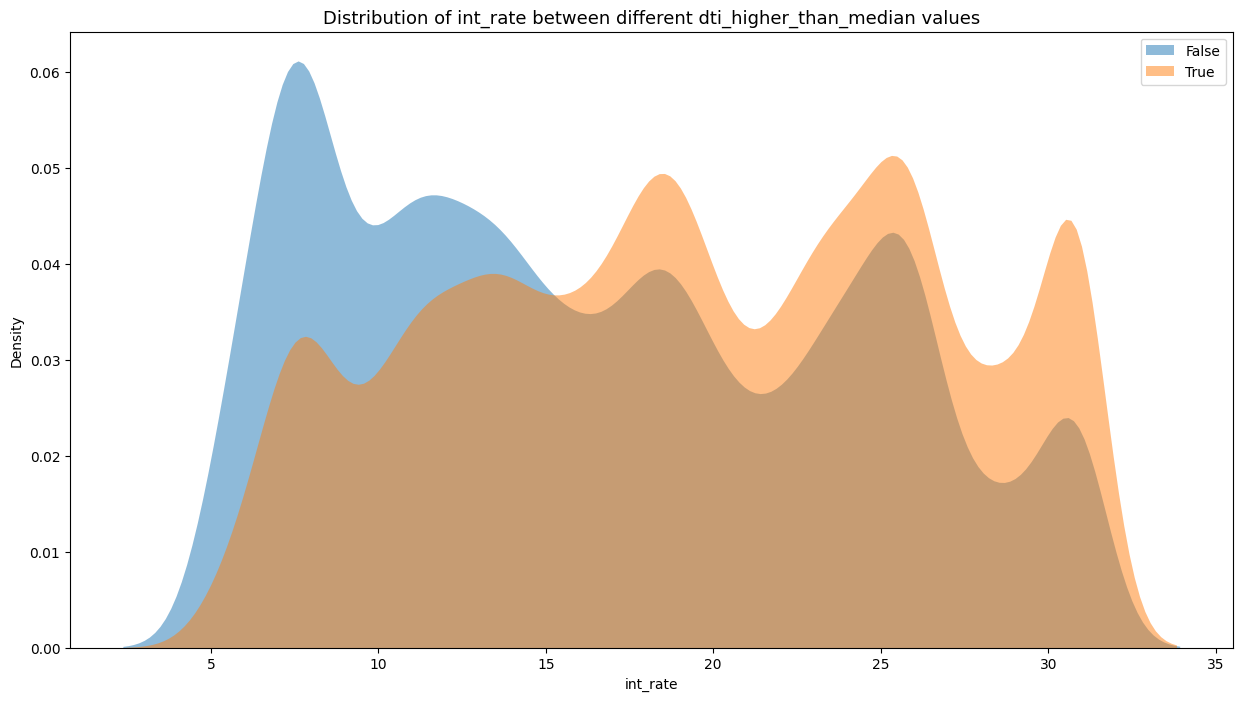

In [25]:
df = df_accepted_step4.copy()
dti_median = df_accepted_step4.dti.median()
df['dti_higher_than_median'] = df_accepted_step4.dti >= dti_median
helpers.plot_kde_plot(df, 'int_rate', 'dti_higher_than_median')

#### Grade

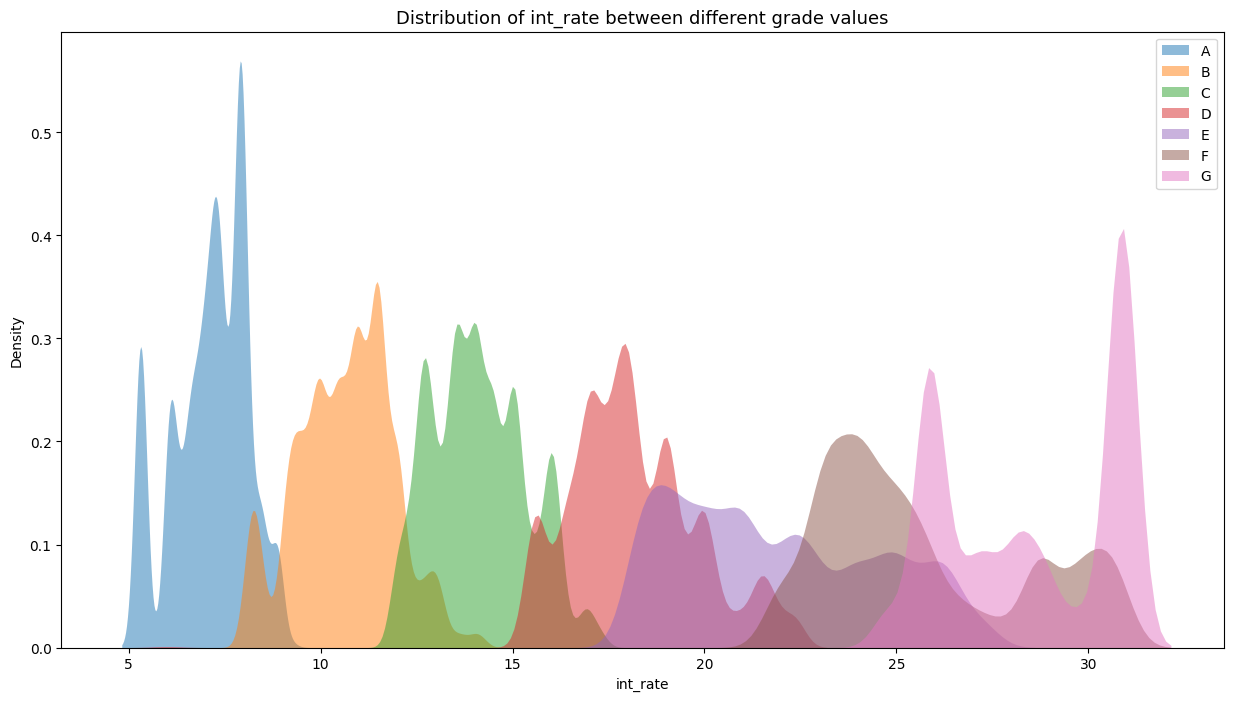

In [26]:
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'grade')

### Sub Grade

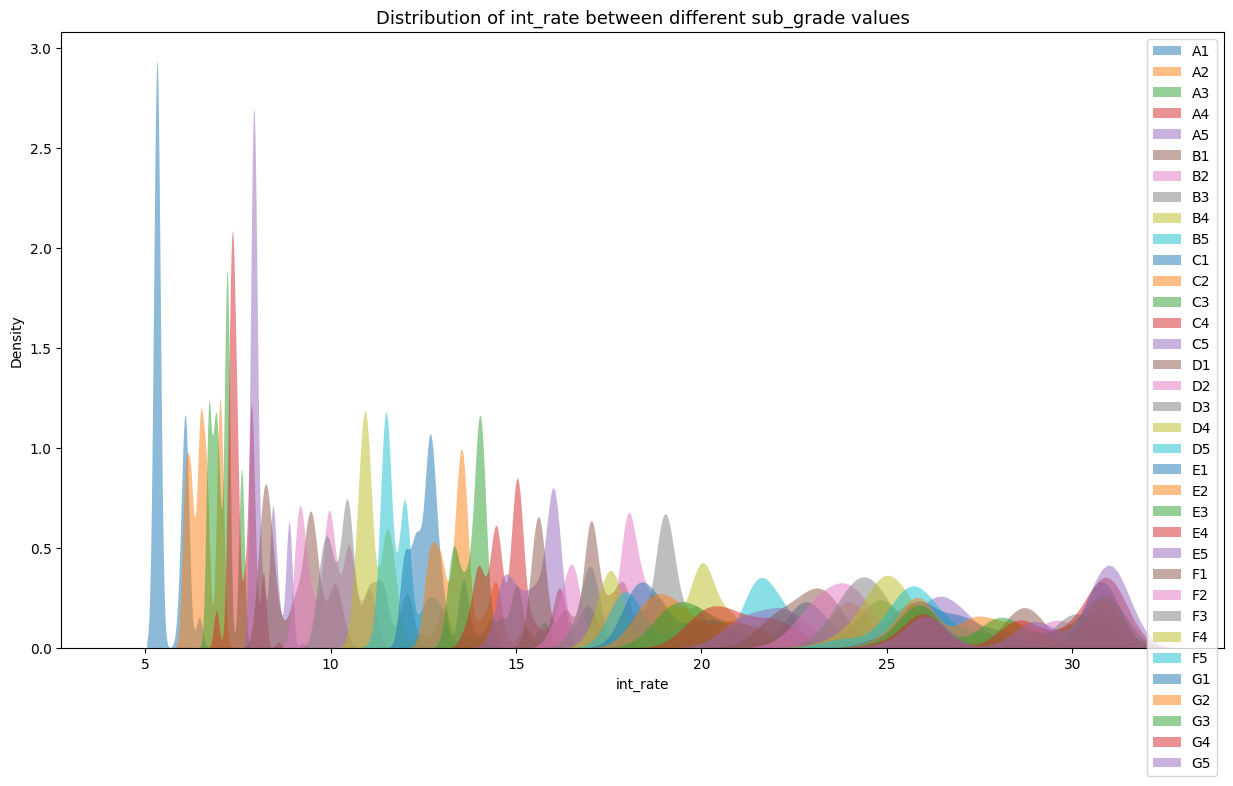

In [27]:
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'sub_grade')

#### Home Ownership

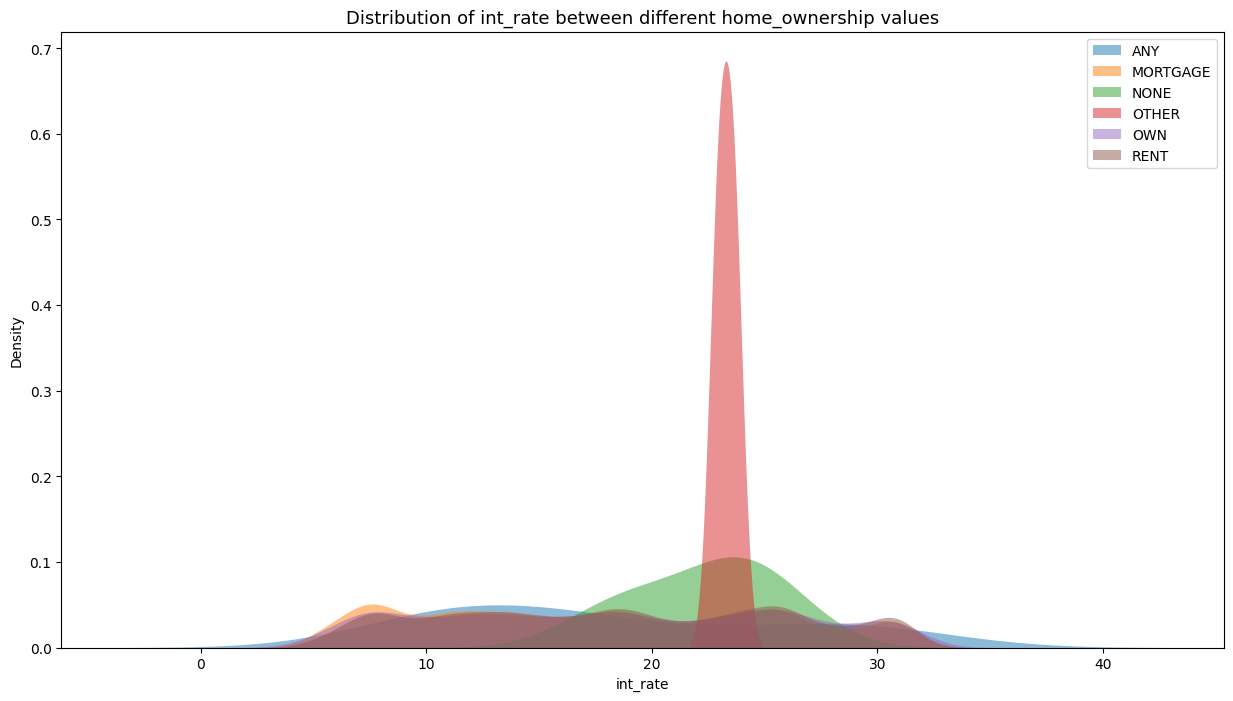

In [28]:
helpers.plot_kde_plot(df_accepted_step4, 'int_rate', 'home_ownership')

#### Num features scatter plots

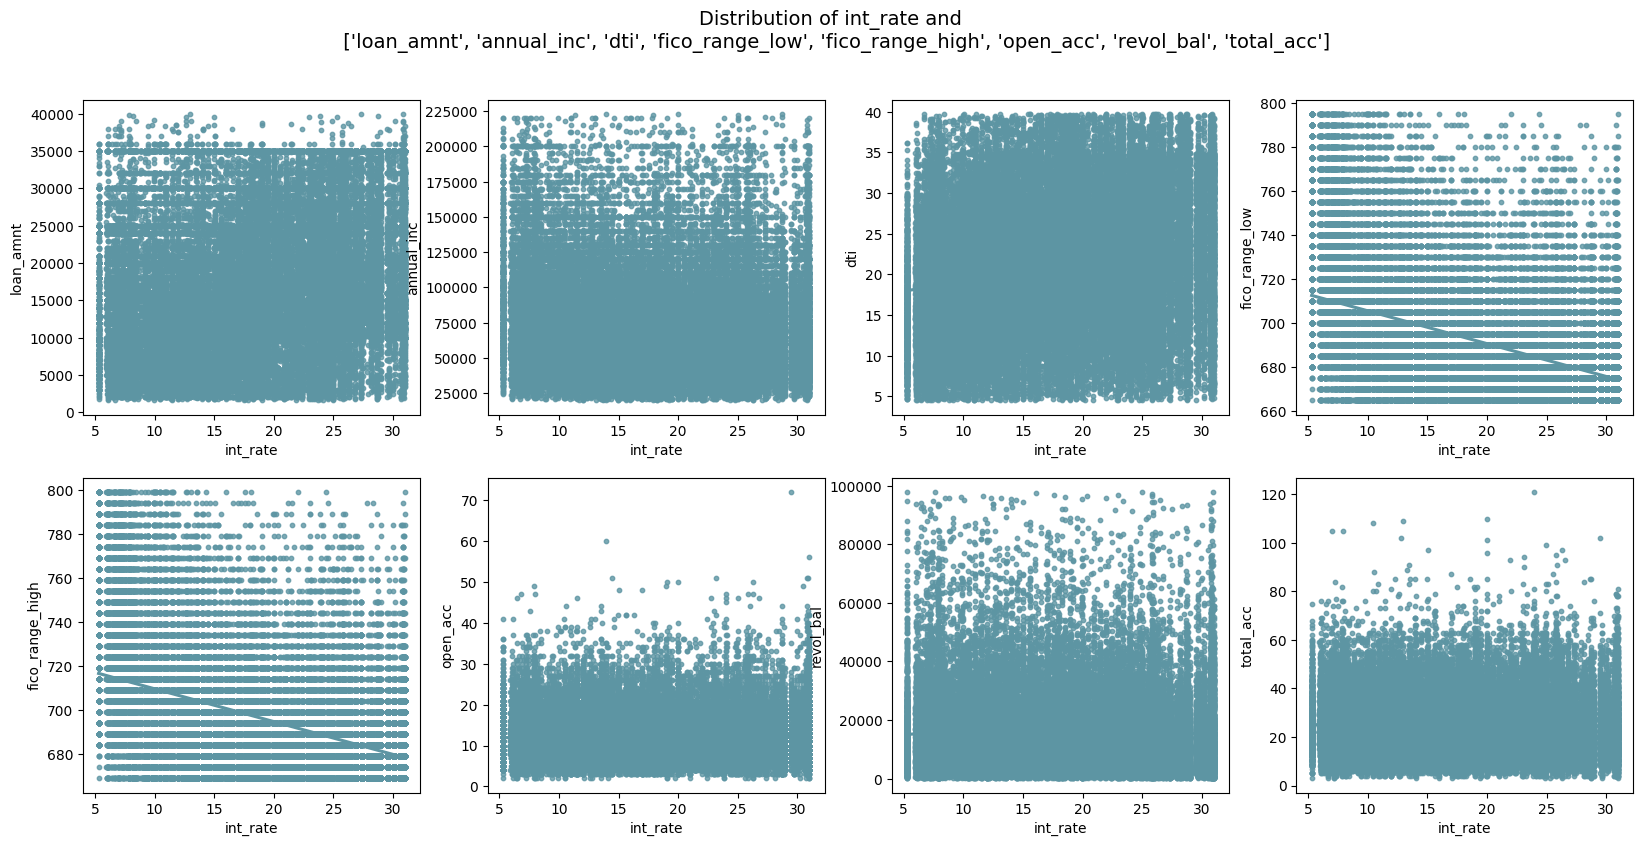

In [29]:
helpers.plot_scatter_plots_with_target(df_accepted_step4, 'int_rate',
                               ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low',
                                'fico_range_high', 'open_acc', 'revol_bal', 'total_acc'])

### Feature Correlation

In [30]:
joint_cols = list( set([col for col in df_accepted_step4.columns if "sec" in col or "joint" in col]))
common_not_joint_cols = [col for col in df_accepted_step4.columns if not ("sec" in col or "joint" in col) and any(col in joint_col for joint_col in joint_cols)]
all_common_cols = joint_cols + common_not_joint_cols

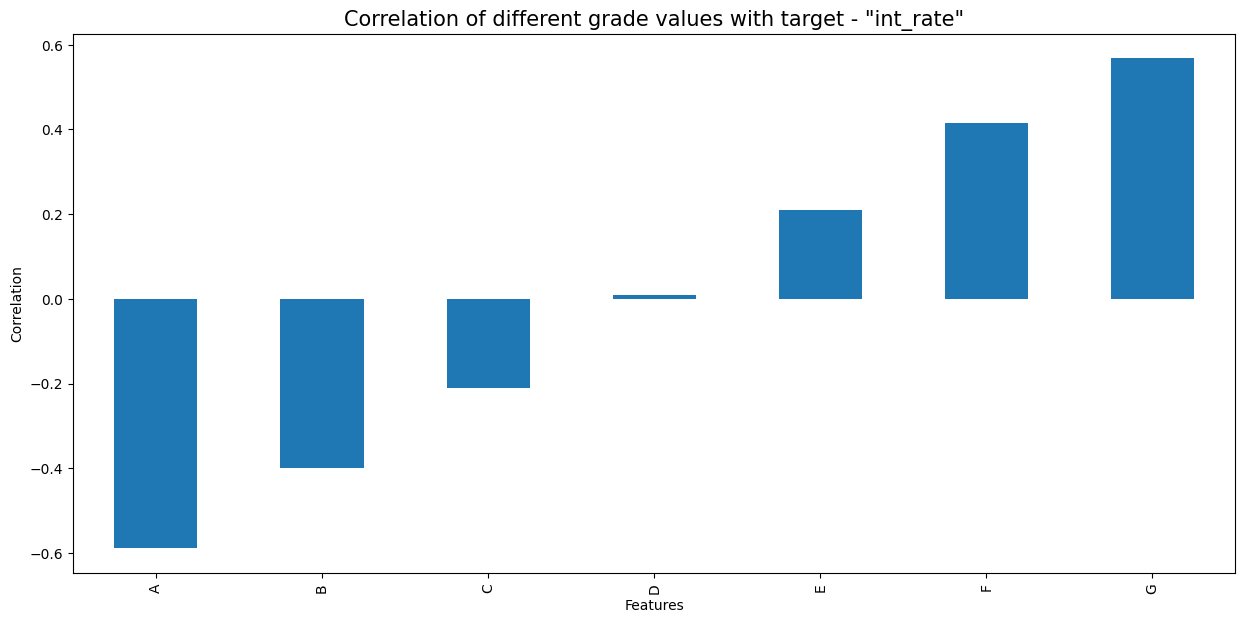

In [31]:
corr_matrix = pd.get_dummies(df_accepted_step4['grade']).corrwith(df_accepted_step4['int_rate']) 
helpers.plot_cat_col_target_corr(corr_matrix, 'grade', 'int_rate')

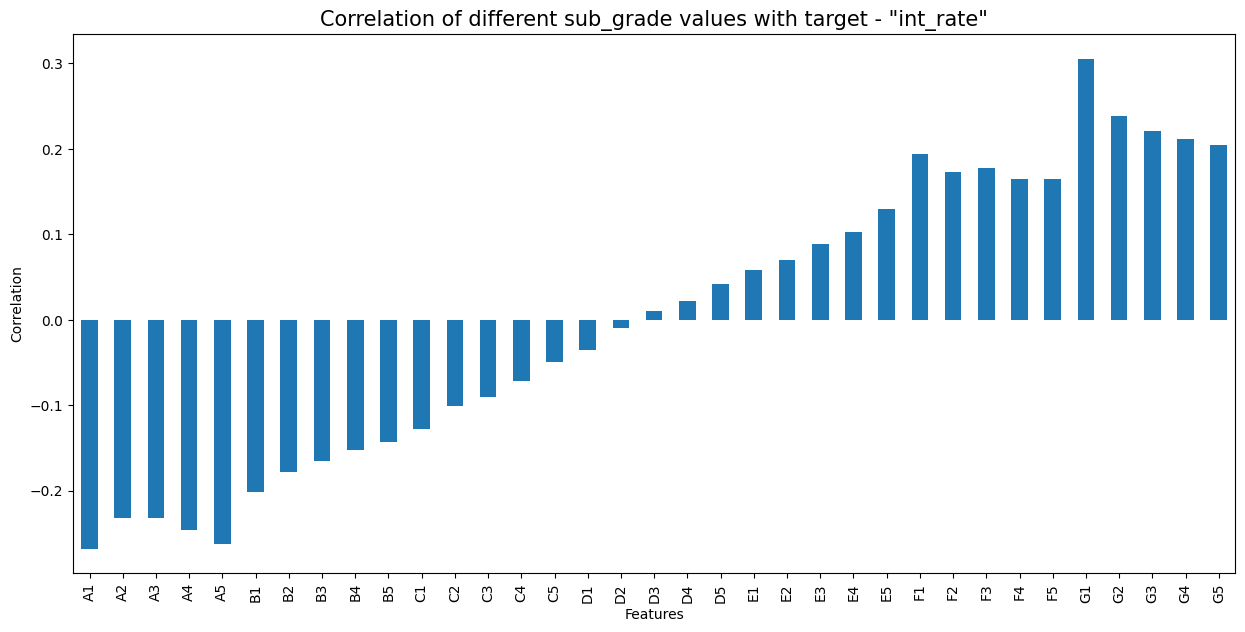

In [32]:
corr_matrix = pd.get_dummies(df_accepted_step4['sub_grade']).corrwith(df_accepted_step4['int_rate']) 
helpers.plot_cat_col_target_corr(corr_matrix, 'sub_grade', 'int_rate')

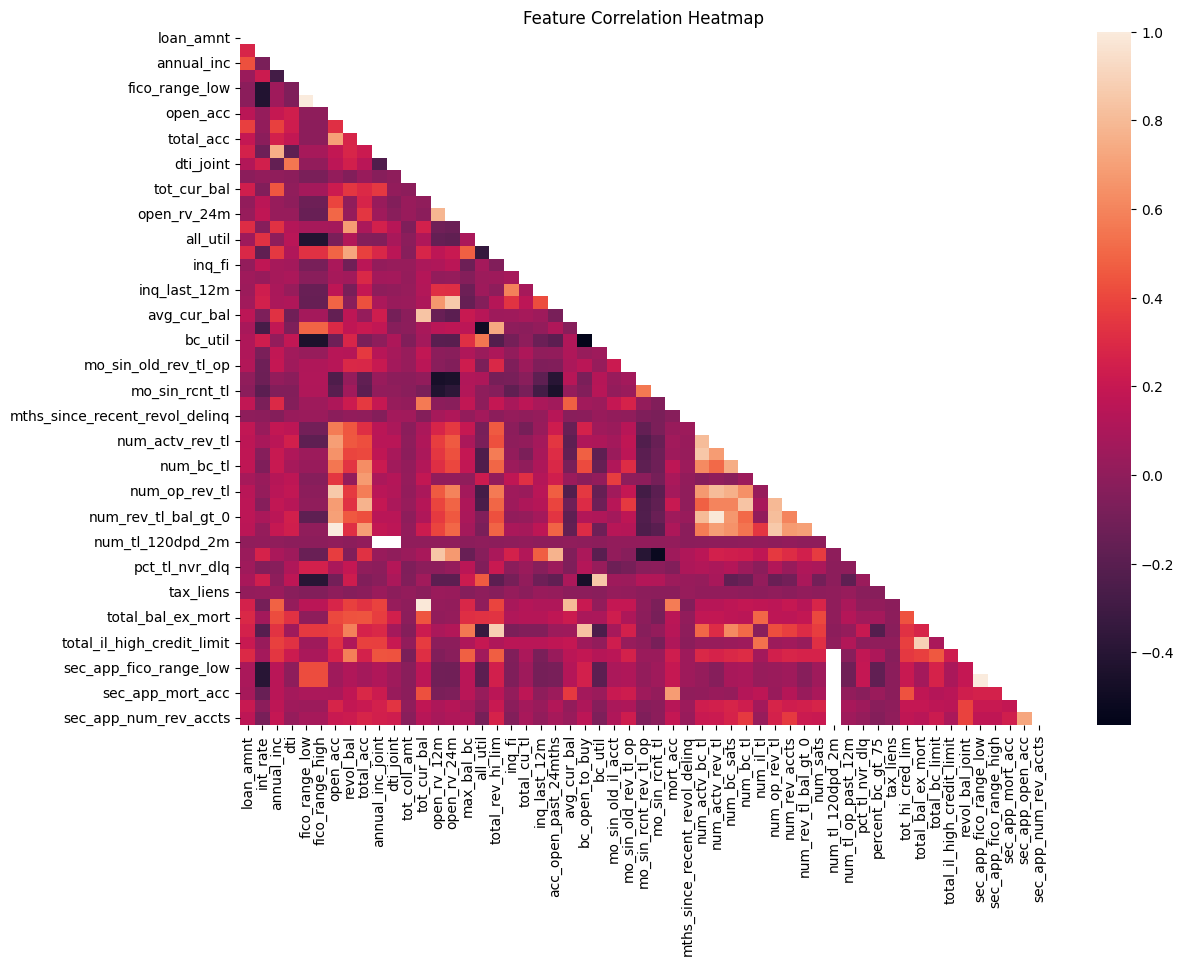

In [33]:
helpers.plot_pearson_corr_map(df_accepted_step4)

In [34]:
to_drop = helpers.get_too_correlated_cols_and_print_pairs(df_accepted_step4, all_common_cols, df_accepted_step4.corrwith(df_accepted_step4["int_rate"]))

num_rev_tl_bal_gt_0 and num_actv_rev_tl are highly correlated: 0.984. The column dropped will be num_actv_rev_tl.
tot_hi_cred_lim and tot_cur_bal are highly correlated: 0.982. The column dropped will be tot_hi_cred_lim.


In [35]:
df_accepted_step4 = df_accepted_step4.drop(to_drop, axis=1)

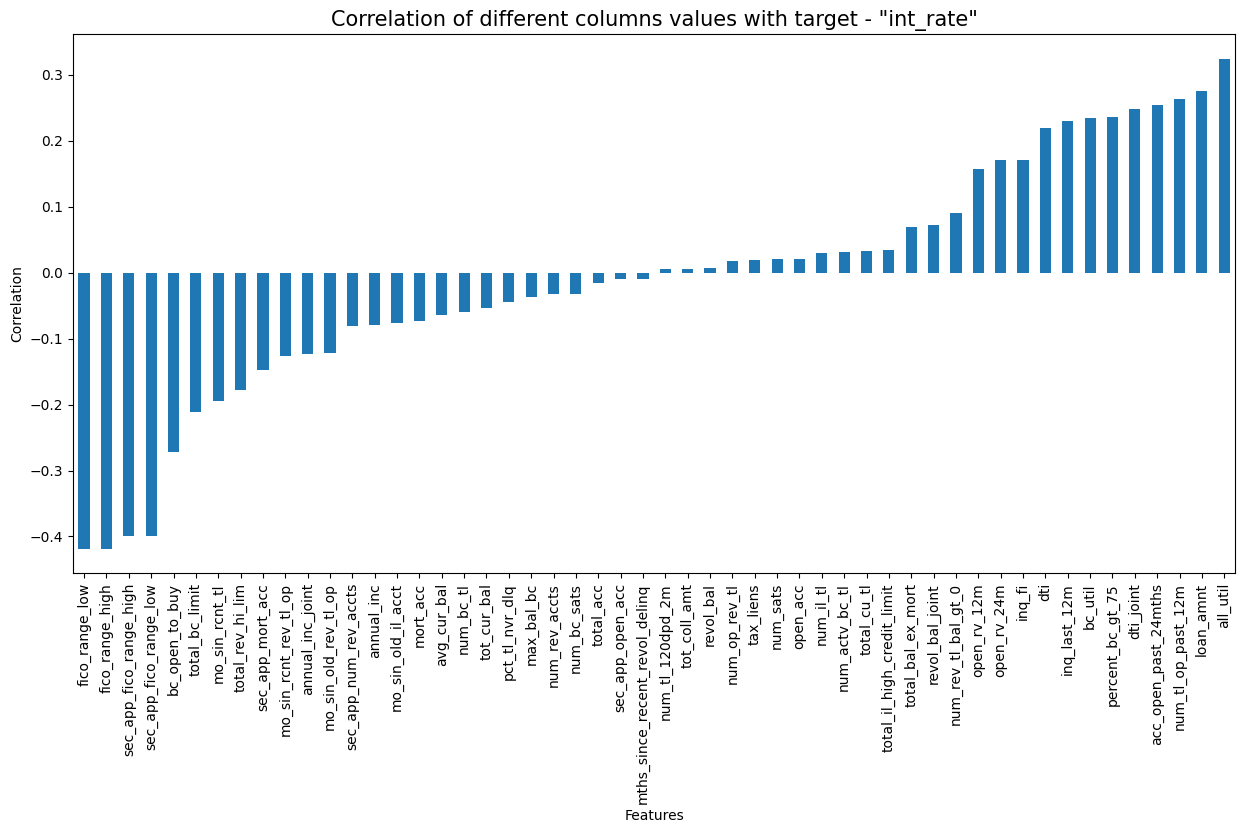

In [36]:
num_cols = df_accepted_step4.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df_accepted_step4[[col for col in num_cols if col != "int_rate"]].corrwith(df_accepted_step4["int_rate"]).sort_values()
helpers.plot_cat_col_target_corr(corr_matrix, 'columns', 'int_rate')

In [37]:
corr_df = pd.DataFrame({"variable": corr_matrix.index, "corr_with_int_rate": corr_matrix.values})
corr_df = corr_df.sort_values("corr_with_int_rate", ascending=False)
df_av_cols = corr_df[(corr_df.variable.isin(all_common_cols) == False) & (corr_df.variable != 'int_rate')]
useless_cols = list(df_av_cols[(df_av_cols.corr_with_int_rate < 0.1) & (df_av_cols.corr_with_int_rate > -0.1)].variable)

In [38]:
df_accepted_step4 = df_accepted_step4.drop(useless_cols, axis=1) 

In [39]:
rejected_cols, not_rejected_cols = helpers.perform_ANOVA_test(df_accepted_step4, all_common_cols)

In [40]:
print("Categorical columns that seem to have a significant difference in means between continuous numerical target.")
rejected_cols

Categorical columns that seem to have a significant difference in means between continuous numerical target.


{'term': 0.0,
 'grade': 0.0,
 'sub_grade': 0.0,
 'home_ownership': 5.3387238269541954e-36,
 'purpose': 0.0,
 'application_type': 4.4835733644286224e-18}

In [41]:
df_accepted_step4 = df_accepted_step4.drop(not_rejected_cols, axis=1) 

In [42]:
if "term" in df_accepted_step4.columns:
    df_accepted_step4['term'] = df_accepted_step4['term'].map({" 36 months": 36, " 60 months": 60})

#### PCA

In [43]:
df_step4_targets = df_accepted_step4[['int_rate']]
df_accepted_step4 = df_accepted_step4.drop(['int_rate'], axis=1)

In [44]:
joint_cols = set([col for col in df_accepted_step4.columns if "sec" in col or "joint" in col])
joint_num_cols = [col for col in joint_cols if df_accepted_step4[col].dtype != "object"]
joint_cat_cols = [col for col in joint_cols if df_accepted_step4[col].dtype == "object"]

In [45]:
numerical_features = df_accepted_step4.select_dtypes(include=[np.number]).columns.tolist() 
cat_features = df_accepted_step4.select_dtypes(include=['object']).columns.tolist()

In [46]:
num_cols = [col for col in numerical_features if col not in joint_cols]
ord_cols = [col for col in df_accepted_step4.columns if col in ['term', 'grade', 'sub_grade']]
ohec_cols = [col for col in df_accepted_step4.columns if col in cat_features and col not in ord_cols]

In [47]:
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split_reg(df_accepted_step4, df_step4_targets, 'int_rate')

In [48]:
preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy())
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 14


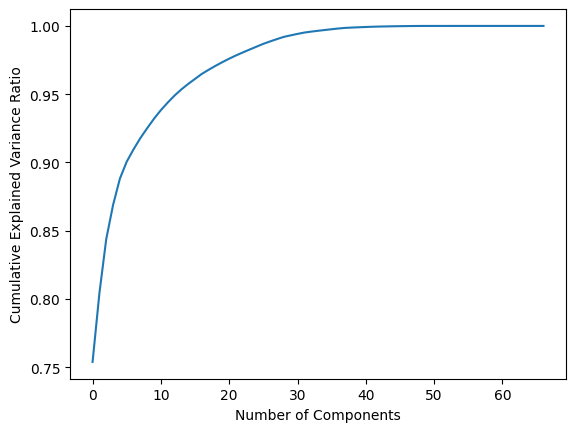

In [49]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.95)

In [50]:
df_ipca, ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.75389251 0.05031564 0.03961363 0.02502364 0.01932644 0.0124111
 0.00904322 0.00825466 0.00726244 0.00693533 0.00624407 0.00552916
 0.00514025 0.00451048]


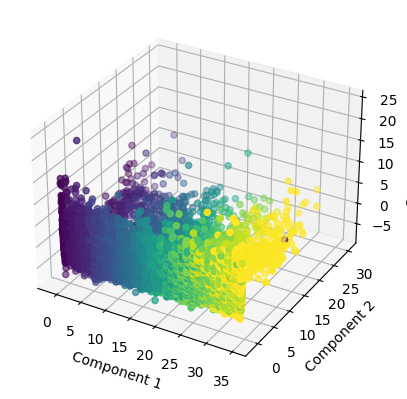

In [51]:
helpers.plot_3_pcas(ipca, X_train_transformed, y_train)

In [52]:
tree_preprocessor = helpers.preprocessor(num_cols.copy(), ohec_cols.copy(), ord_cols.copy(), joint_num_cols.copy(), joint_cat_cols.copy(), "tree")
X_train_transformed = preprocessor.fit_transform(X_train)

Number of components to keep: 14


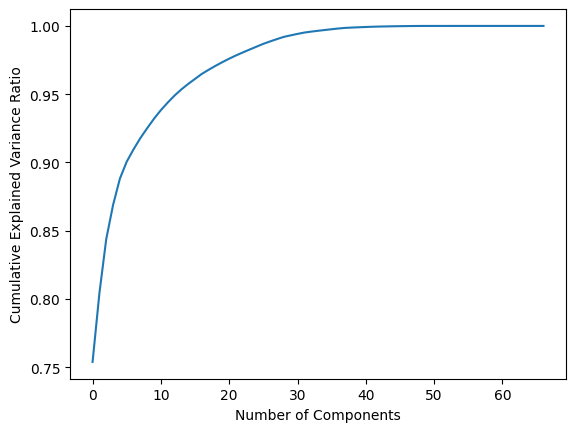

In [53]:
n_components = helpers.plot_ipca_elbow_plot_and_get_n_components(X_train_transformed, 0.95)

In [54]:
df_ipca, tree_ipca= helpers.perform_ipca(n_components, X_train_transformed)

Explained variance ratios: [0.75389251 0.05031564 0.03961363 0.02502364 0.01932644 0.0124111
 0.00904322 0.00825466 0.00726244 0.00693533 0.00624407 0.00552916
 0.00514025 0.00451048]


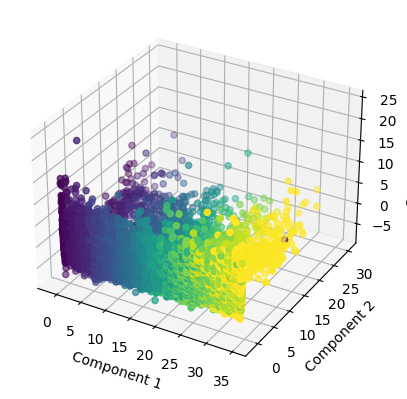

In [55]:
helpers.plot_3_pcas(tree_ipca, X_train_transformed, y_train)

#### Prediction

In [56]:
tree_models = [
                DecisionTreeRegressor(),
                RandomForestRegressor(),
                GradientBoostingRegressor(),
            ]

other_models = [
                LinearRegression(),
                Ridge(),
                Lasso(),
                ElasticNet(), 
                KNeighborsRegressor()
            ]

In [57]:
''' Creating list of pipelines with preprocessor ''' 
pipelines = helpers.getting_pipelines(tree_models, tree_preprocessor, tree_ipca, other_models, preprocessor, ipca)

The **r2_score** (also known as the coefficient of determination) measures the proportion of variance in the target variable that is explained by the independent variables in the regression model. An r2_score of 1.0 indicates a perfect fit, while a score of 0.0 indicates that the model does not explain any of the variance in the target variable.

The **mean_squared_error** (MSE) measures the average squared difference between the predicted and actual values of the target variable. A lower MSE indicates a better fit of the model.

In [58]:
print("The best performing models are:") 
models_results = helpers.try_reg_models(pipelines, X_train, y_train, X_val, y_val)
models_results.iloc[:, 1:]

The best performing models are:


,model_name,r2_score,rmse
1,RandomForestRegressor,0.960462,1.497221
2,GradientBoostingRegressor,0.958726,1.529734
7,KNeighborsRegressor,0.955134,1.594899
3,LinearRegression,0.951624,1.656125
4,Ridge,0.951624,1.656125
6,ElasticNet,0.948648,1.706296
5,Lasso,0.948096,1.715446
0,DecisionTreeRegressor,0.917044,2.168698


In [59]:
results = helpers.optuna_tuning(helpers.objective_reg, models_results.head(5).copy(), X_train, y_train, X_val, y_val, "r2_score") 

Tuned RandomForestRegressor:


In [ ]:
r2_scores = dict(sorted({model[1]: result['r2_score'] for model, result in results.items()}.items(), key=lambda item: item[1], reverse=True))
r2_scores

{'RandomForestRegressor': 0.9618134900954902,
 'GradientBoostingRegressor': 0.9613162514994688,
 'KNeighborsRegressor': 0.9562327267648498,
 'Ridge': 0.9548645518293731,
 'LinearRegression': 0.9548645494837761}

In [ ]:
final_model_results = dict(sorted(results.items(), key=lambda item: item[1]['r2_score'], reverse=True))

In [ ]:
predictions = helpers.get_top_n_models_preds(final_model_results, X_train, y_train, X_val, 4)

In [ ]:
helpers.perform_cross_validation(predictions, X_train, y_train, y_val, score='r2_score') 

ValueError: Found unknown categories ['NONE'] in column 4 during transform

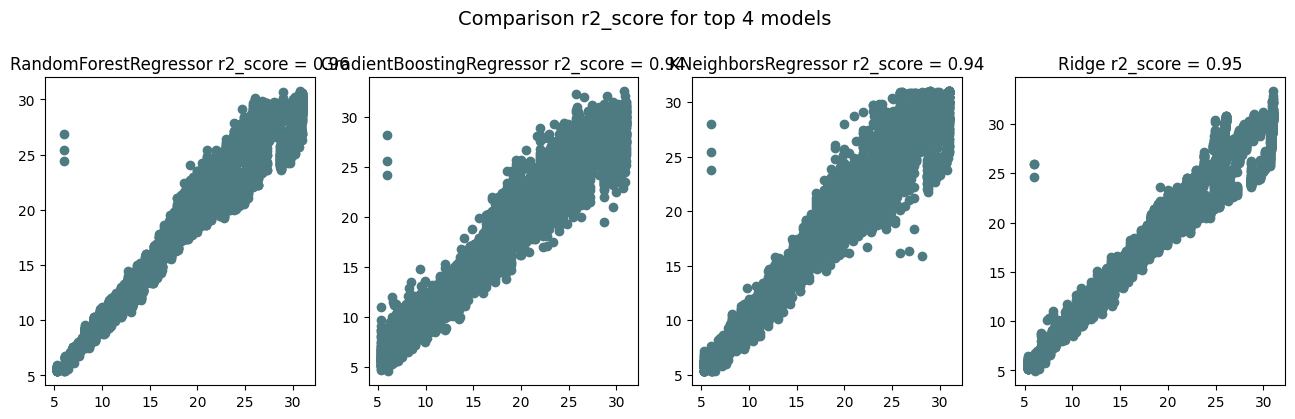

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

fig, axes = plt.subplots(1, len(predictions), figsize=(16, 4))
len_preds = len(predictions)

for i in range(0, len_preds):
    model = list(predictions.items())[i]

    y_pred = model[1]
    model_name = type(model[0].named_steps['model']).__name__
 
    axes[i].scatter(y_val, y_pred, color='#4e7b82')
    r2 = r2_score(y_val, y_pred)
    
    axes[i].set_title(f"{model_name} r2_score = {r2:.2f}")

fig.suptitle("Comparison r2_score for top 4 models", fontsize=14, y=1.05)
fig.show()

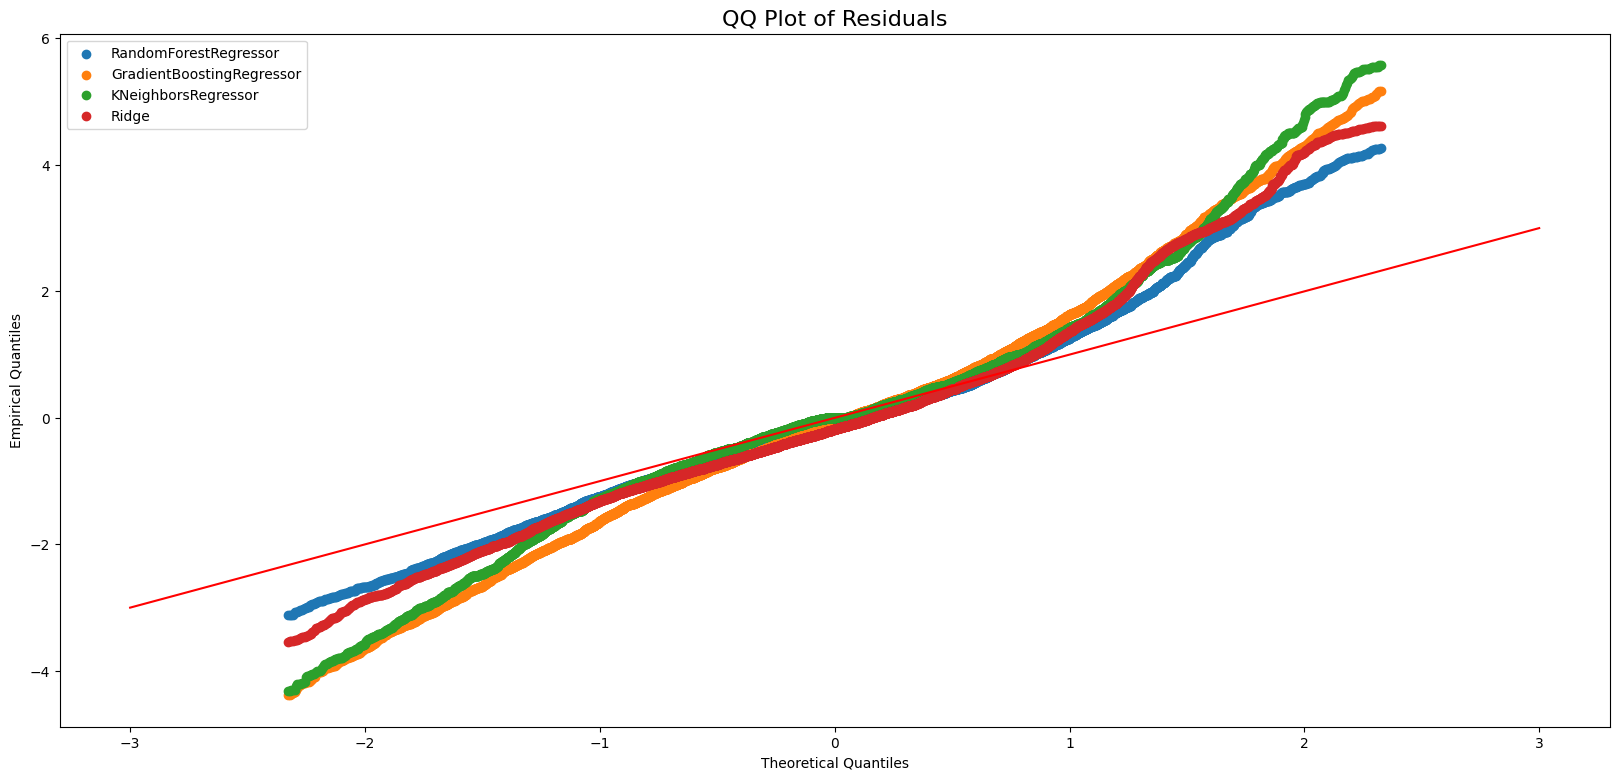

In [ ]:
helpers.plot_qq(predictions, y_val)

,model,mape
1,GradientBoostingRegressor,0.082601
2,KNeighborsRegressor,0.070014
3,Ridge,0.064296
0,RandomForestRegressor,0.057248


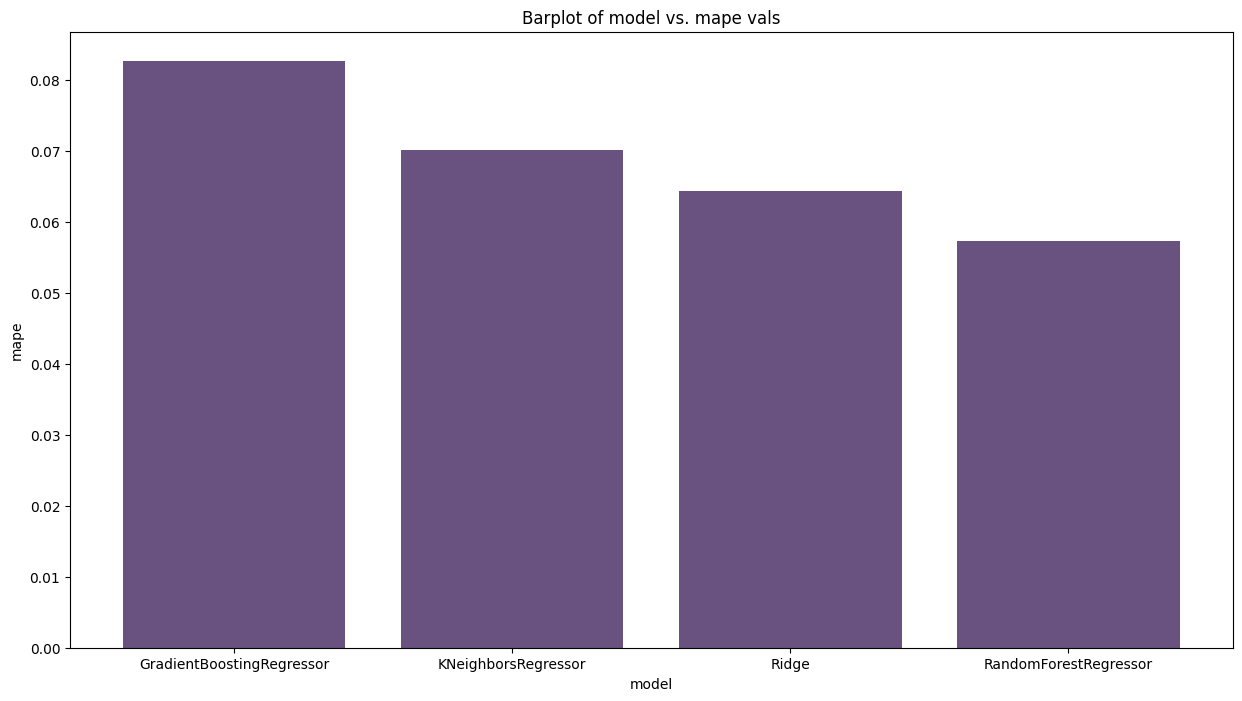

In [ ]:
helpers.count_and_plot_mape_vals(predictions, y_val)

In [ ]:
''' Extracting the best model '''
import pickle

RF_model = list(predictions.keys())[3]
preds = RF_model.predict(X_test)

with open('step2-grade_classifier.pkl', 'wb') as model_file:
    pickle.dump(RF_model, model_file)